# Preprocessing

In dit notebook gaan we de data uit cleaned opsplitsen in drie sets:
- Train: Om het model te leren (meeste data).
- Validation: Om tijdens het trainen te testen hoe goed het gaat (en parameters aan te passen).
- Test: De "eindexamen" set. Deze mag het model nooit zien tijdens het trainen.

Gezien ik weinig Rembrandts heb (167), moeten we voorzichtig zijn. Als we 20% apart zetten voor testen, houden we maar ~130 over om te trainen. Dat is krap, maar met Transfer Learning (wat we later gaan doen) is het mogelijk.

## Nodige imports doen

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

print("Libraries geladen.")

Libraries geladen.


## Nodige variabelen

We kiezen hier voor een Stratified Split. Dat betekent dat we de verhoudingen (veel Picasso, weinig Rembrandt) in elke set gelijk houden. Later lossen we de onbalans op met "Class Weights" of "Augmentation".

In [2]:
BASE_DIR = Path("..")
SOURCE_DIR = BASE_DIR / "datasets" / "cleaned"
DEST_DIR = BASE_DIR / "datasets" / "processed"

# Schilders
PAINTERS = ["Rembrandt", "Picasso", "Mondriaan", "Rubens"]

# Verdeling: 70% Train, 15% Validation, 15% Test
# Waarom? Omdat we weinig Rembrandts hebben, willen we zoveel mogelijk in Train houden.
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Bron: {SOURCE_DIR.resolve()}")
print(f"Doel: {DEST_DIR.resolve()}")

Bron: C:\Projects\DeepLearning_Schilderijnen\datasets\cleaned
Doel: C:\Projects\DeepLearning_Schilderijnen\datasets\processed


## Split functie

Deze functie maakt de mappen train, validation en test aan en kopieert de afbeeldingen.

In [6]:
def split_dataset():
    # 1. Maak de doelmappen leeg/aan
    if DEST_DIR.exists():
        shutil.rmtree(DEST_DIR)
        
    for split in ['train', 'validation', 'test']:
        for painter in PAINTERS:
            (DEST_DIR / split / painter).mkdir(parents=True, exist_ok=True)

    
    summary = {}
    
    for painter in PAINTERS:
        source_path = SOURCE_DIR / painter
        files = list(source_path.glob("*.jpg"))
        
        # Schudden voor willekeurigheid
        np.random.shuffle(files)
        
        # Eerst splitsen we Test eraf (15%)
        train_val_files, test_files = train_test_split(files, test_size=TEST_RATIO, random_state=42)
        
        # Dan splitsen we Validation eraf van wat overblijft
        # We moeten de ratio herberekenen omdat de set kleiner is geworden
        # Als we 15% van totaal willen, en we hebben al 15% weggehaald, is dat:
        # 0.15 / (1.0 - 0.15) = 0.176
        relative_val_ratio = VAL_RATIO / (1 - TEST_RATIO)
        train_files, val_files = train_test_split(train_val_files, test_size=relative_val_ratio, random_state=42)
        
        # Kopiëren van datasets naar de doelmappen
        datasets = {
            'train': train_files,
            'validation': val_files,
            'test': test_files
        }
        
        print(f"Verwerken {painter}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
        
        for split_name, file_list in datasets.items():
            for file_path in file_list:
                dest_path = DEST_DIR / split_name / painter / file_path.name
                shutil.copy2(file_path, dest_path)
                
        summary[painter] = {
            'train': len(train_files),
            'validation': len(val_files),
            'test': len(test_files)
        }

    return summary

print("Start met splitsen...")
split_stats = split_dataset()
print("\nKlaar! Dataset is opgesplitst.")

Start met splitsen...
Verwerken Rembrandt: 116 train, 25 val, 26 test
Verwerken Picasso: 1069 train, 230 val, 230 test
Verwerken Rembrandt: 116 train, 25 val, 26 test
Verwerken Picasso: 1069 train, 230 val, 230 test
Verwerken Mondriaan: 230 train, 50 val, 50 test
Verwerken Mondriaan: 230 train, 50 val, 50 test
Verwerken Rubens: 476 train, 103 val, 103 test
Verwerken Rubens: 476 train, 103 val, 103 test

Klaar! Dataset is opgesplitst.

Klaar! Dataset is opgesplitst.


## Controle 

Het is belangrijk dat we controleren of we genoeg Rembrandts in de training set hebben

--- STATUS REMBRANDT ---
Train:      116 (Dit is weinig, Data Augmentation is nodig!)
Validation: 25
Test:       26


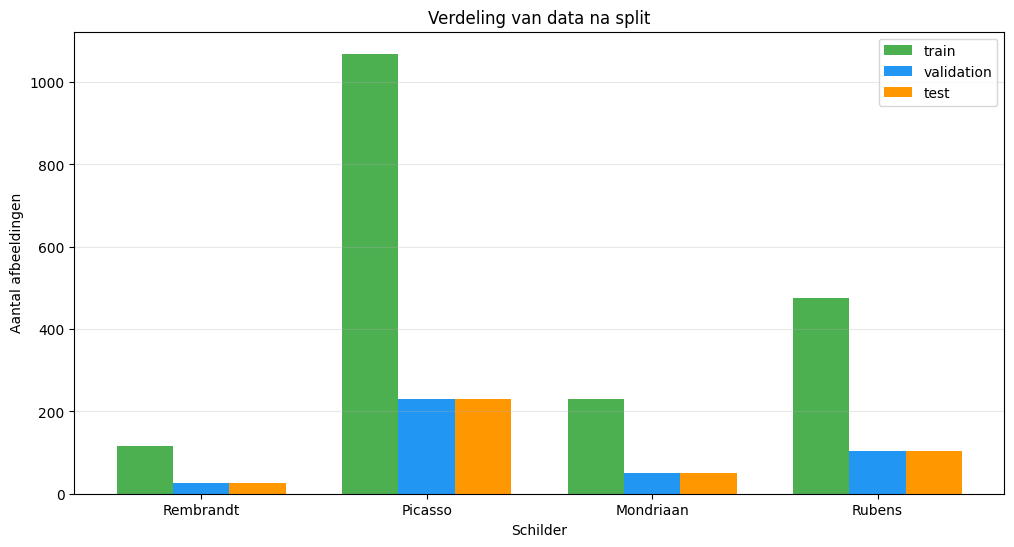

In [7]:
# Even visueel maken
categories = ['train', 'validation', 'test']
colors = ['#4CAF50', '#2196F3', '#FF9800'] # Groen, Blauw, Oranje

plt.figure(figsize=(12, 6))

x = np.arange(len(PAINTERS))
width = 0.25

for i, cat in enumerate(categories):
    counts = [split_stats[painter][cat] for painter in PAINTERS]
    plt.bar(x + i*width, counts, width, label=cat, color=colors[i])

plt.xlabel('Schilder')
plt.ylabel('Aantal afbeeldingen')
plt.title('Verdeling van data na split')
plt.xticks(x + width, PAINTERS)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Print exacte aantallen voor Rembrandt
remb_stats = split_stats['Rembrandt']
print(f"--- STATUS REMBRANDT ---")
print(f"Train:      {remb_stats['train']} (Dit is weinig, Data Augmentation is nodig!)")
print(f"Validation: {remb_stats['validation']}")
print(f"Test:       {remb_stats['test']}")

plt.show()